In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras import Model
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Activation
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [3]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [4]:
base_dir = os.path.join(os.getcwd())
csv_dir = os.path.join(base_dir, 'input_data')
print(csv_dir)

/Users/sinclairliang/Skin-Cancer-Detection/input_data


In [5]:
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.split(x)[1].split('.')[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
print('{} Images in the directory'.format(len(imageid_path_dict)))

10015 Images in the directory


In [6]:
# input_data_path = os.path.join(base_skin_dir, 'input_data')
skin_df = pd.read_csv(os.path.join(csv_dir, 'HAM10000_metadata.csv'))## Creating data frame

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/sinclairliang/Skin-Cancer-Detection/HAM...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/sinclairliang/Skin-Cancer-Detection/HAM...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/sinclairliang/Skin-Cancer-Detection/HAM...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/sinclairliang/Skin-Cancer-Detection/HAM...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/sinclairliang/Skin-Cancer-Detection/HAM...,Benign keratosis-like lesions,2


In [8]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id        10015 non-null object
image_id         10015 non-null object
dx               10015 non-null object
dx_type          10015 non-null object
age              9958 non-null float64
sex              10015 non-null object
localization     10015 non-null object
path             10015 non-null object
cell_type        10015 non-null object
cell_type_idx    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


In [9]:
#replacing the NaN values in age with the mean of the ages
skin_df = skin_df.fillna(skin_df['age'].mean())

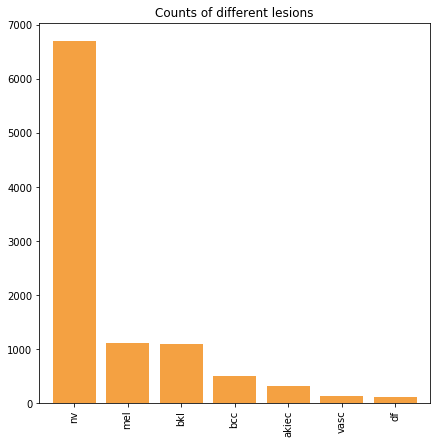

In [10]:
ax = skin_df['dx'].value_counts().plot.bar(figsize=(7,7), width=.8, color='#f4a142')
plt.title('Counts of different lesions')
plt.show()

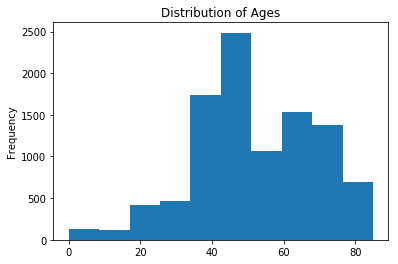

In [11]:
skin_df['age'].plot.hist()
plt.title('Distribution of Ages')
plt.show()

## The types of lesions
These are some samples of the different types of leions we're looking at in the dataset. Most of the different types of skin lesions in this dataset are either cancerous or pre-cancerous although some a just benign.

* **Melanocytic Nevi** - A usually noncancerous disorder of pigment-producing skin cells commonly called birth marks or moles
* **Melanoma** - One of the most serious types of skin cancer
* **Benign Keratosis-like Lesions** - A harmless growth on the skin
* **Basal Cell Carninoma** - A type of cancer that arises due to sun exposure
* **Actinic Keratosis** - A scaly growth caused by damage from exposure to the sun, the most common type of precancerous skin lesion
* **Vascular Lesions** - Comprise of all skin disease that originate from or affect blood, including malignant or benign tumors
* **Dermatofibroma** - A benign growth of the skin

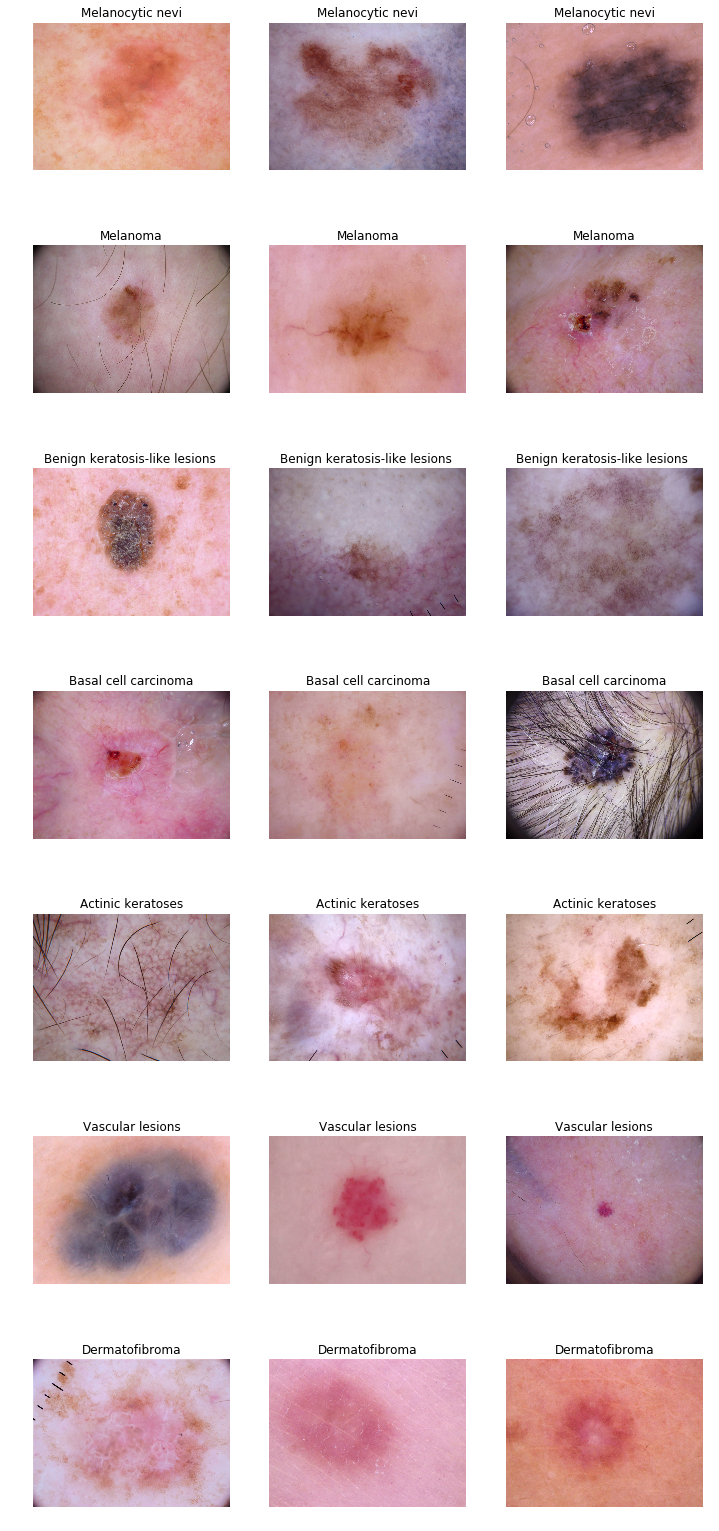

In [12]:
import matplotlib.image as mpimg
ncols = 3
nrows = 7
image_paths = {}
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for x in lesion_type_dict:
    image_paths.update({x:skin_df.query('dx == "{}"'.format(x))['path'].sample(n=3)})
count = 1
for key in image_paths:
    paths = image_paths[key]
    for i, path in enumerate(paths):
        sp = plt.subplot(nrows, ncols, count)
        sp.axis('Off') # Don't show axes (or gridlines)
        img = mpimg.imread(path)
        count += 1
        sp.set_title(lesion_type_dict[key])
        plt.imshow(img)
plt.show()

In [13]:
#Splitting the data into testing, validation, and training data
X_train, X_test  = train_test_split(skin_df, test_size=.251123, random_state=123)
X_train, X_valid = train_test_split(X_train, test_size=.20, random_state=123)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 3158 to 8077
Data columns (total 10 columns):
lesion_id        6000 non-null object
image_id         6000 non-null object
dx               6000 non-null object
dx_type          6000 non-null object
age              6000 non-null float64
sex              6000 non-null object
localization     6000 non-null object
path             6000 non-null object
cell_type        6000 non-null object
cell_type_idx    6000 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 474.6+ KB


In [15]:
#Create separate testing and training folders
cwd = os.getcwd()
train_dir = os.path.join(cwd, 'train')
test_dir = os.path.join(cwd, 'test')
valid_dir = os.path.join(cwd, 'valid')

dirs = [train_dir, test_dir, valid_dir]
for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

In [16]:
#Moving the images into the appropriate folder
from shutil import copy2
data = {'train':X_train, 'test':X_test, 'valid':X_valid}
for df in data:
    for index, row in data[df].iterrows():
        new_dir = os.path.join(cwd, df, row['dx'])
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        if not os.path.isfile(os.path.join(new_dir, os.path.basename(row['path']))):
            copy2(row['path'], new_dir)

In [17]:
image_input = Input(shape=(120,90,3))
x = Conv2D(64, 3, activation='relu')(image_input)
x = MaxPool2D(2)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D(2)(x)

x = Conv2D(128, 2, activation='relu')(x)
x = MaxPool2D(2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

x = Dropout(.3)(x)

out = Dense(7, activation='softmax')(x)

In [18]:
model = Model(image_input, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 90, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 88, 64)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 21, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 20, 128)       65664     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 10, 128)       0         
__________

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# Training Image Data Generator
tidg = ImageDataGenerator(rescale=1./255,
        rotation_range=.4,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = tidg.flow_from_directory(
        train_dir,
        target_size = (120, 90),
        batch_size = 60,
        class_mode = 'categorical')


vidg = ImageDataGenerator(rescale=1./255,
        rotation_range=.4,
        zoom_range=0.2,
        horizontal_flip=True)


valid_generator = vidg.flow_from_directory(
        valid_dir,
        target_size = (120, 90),
        batch_size = 30,
        class_mode = 'categorical')

Found 6000 images belonging to 7 classes.
Found 1500 images belonging to 7 classes.


In [21]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 15,
      validation_data = valid_generator,
      validation_steps = 50,
      verbose = 1)


# from keras.models import load_model
# history = load_model(os.path.join(base_dir, 'skin_model(74).h5'))

Epoch 1/15
100/100 [==============================] - 122s 1s/step - loss: 1.0561 - acc: 0.6658 - val_loss: 0.9329 - val_acc: 0.6787
Epoch 2/15
100/100 [==============================] - 116s 1s/step - loss: 0.9232 - acc: 0.6717 - val_loss: 0.9187 - val_acc: 0.6767
Epoch 3/15
100/100 [==============================] - 116s 1s/step - loss: 0.8739 - acc: 0.6813 - val_loss: 0.8741 - val_acc: 0.6827
Epoch 4/15
100/100 [==============================] - 116s 1s/step - loss: 0.8115 - acc: 0.6997 - val_loss: 0.8276 - val_acc: 0.6953
Epoch 5/15
100/100 [==============================] - 115s 1s/step - loss: 0.7976 - acc: 0.7095 - val_loss: 0.8661 - val_acc: 0.6813
Epoch 6/15
100/100 [==============================] - 115s 1s/step - loss: 0.7525 - acc: 0.7182 - val_loss: 0.7895 - val_acc: 0.7067
Epoch 7/15
100/100 [==============================] - 115s 1s/step - loss: 0.7319 - acc: 0.7232 - val_loss: 0.7573 - val_acc: 0.7227
Epoch 8/15
100/100 [==============================] - 115s 1s/step - 

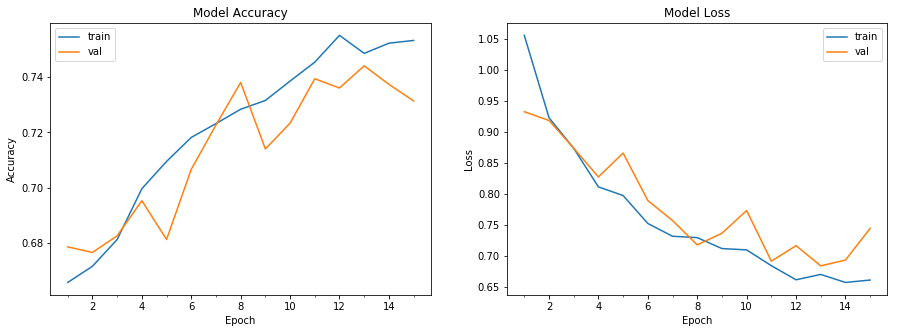

In [22]:
plot_model_history(history)

In [23]:
model.save('skin_model.h5')

In [24]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir,
        target_size=(120, 90),
        class_mode='categorical',
        batch_size=10)

model.predict_generator(test_generator,
                        steps = 100,
                        verbose=1)

Found 2515 images belonging to 7 classes.
100/100 [==============================] - 9s 88ms/step


array([[1.5189950e-07, 3.5730579e-08, 2.5420669e-03, ..., 4.0693241e-05,
        9.9741685e-01, 6.7094008e-10],
       [8.4236538e-04, 1.5721855e-03, 2.2081502e-01, ..., 3.2308340e-01,
        4.5338425e-01, 2.4481020e-05],
       [6.0666481e-09, 1.1786210e-07, 1.3154765e-05, ..., 7.6577981e-06,
        9.9997723e-01, 2.5314912e-07],
       ...,
       [1.5238998e-08, 2.4146806e-07, 1.2901948e-05, ..., 1.3251924e-04,
        9.9985385e-01, 8.3241119e-08],
       [2.9158261e-01, 1.1078230e-01, 4.4320816e-01, ..., 5.6233864e-02,
        9.0173185e-02, 6.2966210e-05],
       [6.0441994e-06, 1.1420398e-05, 1.8074892e-03, ..., 4.7320189e-04,
        9.9769503e-01, 8.1254166e-07]], dtype=float32)

In [29]:
# Confusion Matrix 

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Predict the values from the validation dataset
# y_pred = model.predict(X_test)
# # Convert predictions classes to one hot vectors 
# y_pred_classes = np.argmax(y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# y_true = np.argmax(Y_test,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(7)) 

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (2515, 10)